# A1: That's What I LIKE

**by Dechathon Niamsa-ard [st126235]**

## Task 1. Preparation and Training
Build upon the code discussed in class. Do not use pre-built
solutions from the internet.
1) Read and understand the Word2Vec1 and GloVe2 papers.
2) Modify the Word2Vec (with & without negative sampling) and GloVe from the lab lecture (3 points)
   - Train using a real-world corpus (suggest to categories news from nltk datset). Ensure to source this dataset from reputable public databases or repositories. It is imperative to give proper credit to the dataset source in your documentation.
   - Create a function that allows dynamic modification of the window size during training. Use a window size of 2 as default.

### Import necessary libraries

In [1]:
# Import necessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import Counter
import random
import time
from tqdm import tqdm
import nltk
from scipy.stats import spearmanr # For calculating correlation with human judgments
import gensim.downloader as api # For downloading pre-trained models
import pandas as pd
import math
import os

# Check the version of numpy and torch
print(f"Numpy version: {np.__version__}")
print(f"Torch version: {torch.__version__}")

# Set up torch device to use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Download necessary NLTK data (corpus and tokenizer)
nltk.download('brown', quiet=True)
nltk.download('punkt', quiet=True)

Numpy version: 2.4.1
Torch version: 2.9.1+cu130
Using device: cuda


True

### Load and prepare the dataset

Dataset:  Brown Corpus - Francis, W., & Kucera, H. (1979).

Category: news

In [2]:
# Load the NLTK brown corpus (news category)
from nltk.corpus import brown

# Load sentences from the 'news' category of the Brown corpus
corpus = brown.sents(categories='news')

# Preprocessing:
# 1. Flatten to list of sentences, lowercase all words
corpus = [[word.lower() for word in sent] for sent in corpus]
# 2. Filter out non-alpha words (remove punctuation, number) to keep it simple and smaller
corpus = [[word for word in sent if word.isalpha()] for sent in corpus]
# 3. Remove empty sentences after filtering
corpus = [sent for sent in corpus if len(sent) > 0]

print(f"Number of sentences: {len(corpus)}")
print(f"Sample sentence: {corpus[0]}")

# Numericalization
# Create a list of all words in the corpus flattened
flatten = lambda l: [item for sublist in l for item in sublist]
vocabs = list(set(flatten(corpus))) # Get unique words
word2index = {v:idx for idx, v in enumerate(vocabs)}

# Add <UNK> token for unknown words to handle out-of-vocabulary words
vocabs.append('<UNK>')
word2index['<UNK>'] = len(vocabs) - 1
index2word = {v:k for k, v in word2index.items()}

print(f"Vocabulary size: {len(vocabs)}")

Number of sentences: 4604
Sample sentence: ['the', 'fulton', 'county', 'grand', 'jury', 'said', 'friday', 'an', 'investigation', 'of', 'recent', 'primary', 'election', 'produced', 'no', 'evidence', 'that', 'any', 'irregularities', 'took', 'place']
Vocabulary size: 11152


### Define Models

#### 1. Skipgram: Standard Word2Vec with Softmax

In [3]:
class Skipgram(nn.Module):
    """Standard Skipgram Word2Vec model with softmax."""
    
    def __init__(self, voc_size, emb_size):
        super(Skipgram, self).__init__()
        # Two embeddings: one for when the word is center, one for when it's context (outside)
        self.embedding_center  = nn.Embedding(voc_size, emb_size)
        self.embedding_outside = nn.Embedding(voc_size, emb_size)
    
    def forward(self, center, outside, all_vocabs):
        # Get embeddings for center and outside words
        center_embedding     = self.embedding_center(center)  # (batch_size, 1, emb_size)
        outside_embedding    = self.embedding_outside(outside)  # (batch_size, 1, emb_size)
        all_vocabs_embedding = self.embedding_outside(all_vocabs)  # (batch_size, voc_size, emb_size)
        
        # Calculate dot product between center and correct outside word
        top_term = torch.exp(outside_embedding.bmm(center_embedding.transpose(1, 2)).squeeze(2))
        
        # Calculate dot product between center and ALL words (for Softmax denominator)
        lower_term = all_vocabs_embedding.bmm(center_embedding.transpose(1, 2)).squeeze(2)
        lower_term_sum = torch.sum(torch.exp(lower_term), 1)  # (batch_size, 1)
        
        # Cross Entropy Loss
        loss = -torch.mean(torch.log(top_term / lower_term_sum))  # scalar
        return loss
    
    def get_embedding(self, word_idx):
        """Get word embedding by averaging center and outside embeddings."""
        word_tensor = torch.LongTensor([word_idx]).to(next(self.parameters()).device)
        embed_c = self.embedding_center(word_tensor)
        embed_o = self.embedding_outside(word_tensor)
        return ((embed_c + embed_o) / 2).detach().cpu().numpy().flatten()

#### 2. SkipgranNeg: Word2Vec with negative sampling

In [4]:
class SkipgramNeg(nn.Module):
    """Skipgram Word2Vec with Negative Sampling."""
    
    def __init__(self, voc_size, emb_size):
        super(SkipgramNeg, self).__init__()
        self.embedding_center  = nn.Embedding(voc_size, emb_size)
        self.embedding_outside = nn.Embedding(voc_size, emb_size) # Context embedding
        self.logsigmoid        = nn.LogSigmoid() # LogSigmoid for stable computation
    
    def forward(self, center, outside, negative):
        # Get embeddings
        center_embed   = self.embedding_center(center)  # (bs, 1, emb_size)
        outside_embed  = self.embedding_outside(outside)  # (bs, 1, emb_size)
        negative_embed = self.embedding_outside(negative)  # (bs, k, emb_size)
        
        # Positive Sample Score: dot(u_o, v_c)
        uovc           = outside_embed.bmm(center_embed.transpose(1, 2)).squeeze(2)  # (bs, 1)
        
        # Negative Sample Score: dot(u_k, v_c) -> maximize - dot -> minimize dot
        ukvc           = -negative_embed.bmm(center_embed.transpose(1, 2)).squeeze(2)  # (bs, k)
        ukvc_sum       = torch.sum(ukvc, 1).reshape(-1, 1)  # (bs, 1)
        
        # Loss: - [log(sigmoid(u_o*v_c)) + sum(log(sigmoid(-u_k*v_c)))]
        loss           = self.logsigmoid(uovc) + self.logsigmoid(ukvc_sum)
        return -torch.mean(loss)
    
    def get_embedding(self, word_idx):
        """Get word embedding by averaging center and outside embeddings."""
        word_tensor = torch.LongTensor([word_idx]).to(next(self.parameters()).device)
        embed_c = self.embedding_center(word_tensor)
        embed_o = self.embedding_outside(word_tensor)
        return ((embed_c + embed_o) / 2).detach().cpu().numpy().flatten()

#### 3. GloVe: GloVe model

In [5]:
class Glove(nn.Module):
    """GloVe model implementation."""
    
    def __init__(self, voc_size, emb_size):
        super(Glove, self).__init__()
        self.center_embedding  = nn.Embedding(voc_size, emb_size)
        self.outside_embedding = nn.Embedding(voc_size, emb_size)
        self.center_bias       = nn.Embedding(voc_size, 1) # Bias for center words
        self.outside_bias      = nn.Embedding(voc_size, 1) # Bias for outside words
    
    def forward(self, center, outside, coocs, weighting):
        center_embeds  = self.center_embedding(center)  # (batch_size, 1, emb_size)
        outside_embeds = self.outside_embedding(outside)  # (batch_size, 1, emb_size)
        
        center_bias    = self.center_bias(center).squeeze(1)
        target_bias    = self.outside_bias(outside).squeeze(1)
        
        # Dot product
        inner_product  = outside_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        
        # GloVe Loss: f(X_ij) * (w_i^T w_j + b_i + b_j - log(X_ij))^2
        loss = weighting * torch.pow(inner_product + center_bias + target_bias - coocs, 2)
        
        return torch.sum(loss)
    
    def get_embedding(self, word_idx):
        """Get word embedding by averaging center and outside embeddings."""
        word_tensor = torch.LongTensor([word_idx]).to(next(self.parameters()).device)
        embed_c = self.center_embedding(word_tensor)
        embed_o = self.outside_embedding(word_tensor)
        return ((embed_c + embed_o) / 2).detach().cpu().numpy().flatten()

#### 4. Gensim GloVe model (Pretrained-model)
Load from: https://github.com/piskvorky/gensim-data?tab=readme-ov-file

In [6]:
# Load Gensim GloVe model from pretrained vectors
try:
    glove_gensim = api.load("glove-wiki-gigaword-100")
    print("Gensim GloVe model loaded.")
except Exception as e:
    print(f"Failed to load gensim model: {e}")
    glove_gensim = None

Gensim GloVe model loaded.


### Create a Helper Function with Dynamic Window Size

In [7]:
def random_batch_skipgram(batch_size, corpus, word2index, window_size=2):
    """Generate random batch for Skipgram training with dynamic window size."""
    skipgrams = []
    # Loop through each document/sentence
    for doc in corpus:
        # Iterate through words, avoiding indices out of bounds
        for i in range(window_size, len(doc) - window_size):
            center = word2index.get(doc[i], word2index['<UNK>'])
            outside = []
            # Collect context words within window_size
            for j in range(1, window_size + 1):
                outside.append(word2index.get(doc[i-j], word2index['<UNK>']))
                outside.append(word2index.get(doc[i+j], word2index['<UNK>']))
            # Create pairs (center, outside)
            for each_out in outside:
                skipgrams.append([center, each_out])
    
    # Adjust batch size if dataset is small
    if len(skipgrams) < batch_size:
        batch_size = len(skipgrams)
    
    # Randomly sample a batch
    random_index = np.random.choice(range(len(skipgrams)), batch_size, replace=False)
    inputs, labels = [], []
    for index in random_index:
        inputs.append([skipgrams[index][0]])
        labels.append([skipgrams[index][1]])
    
    return np.array(inputs), np.array(labels)


def prepare_sequence(seq, word2index):
    """Convert word sequence to index tensor."""
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index['<UNK>'], seq))
    return torch.LongTensor(idxs)


def negative_sampling(targets, unigram_table, k, word2index):
    """Sample k negative examples for each target."""
    batch_size = targets.shape[0]
    neg_samples = []
    for i in range(batch_size):
        target_index = targets[i].item()
        nsample = []
        while len(nsample) < k:
            # Randomly select a word from the unigram table
            neg = random.choice(unigram_table)
            # Ensure negative sample is not the target itself (unlikely but possible)
            if word2index.get(neg, -1) == target_index:
                continue
            nsample.append(neg)
        neg_samples.append(prepare_sequence(nsample, word2index).reshape(1, -1))
    return torch.cat(neg_samples)  # batch_size, k


def prepare_glove_data(corpus, word2index, window_size=2):
    """Prepare co-occurrence matrix and weighting for GloVe with dynamic window size."""
    skip_grams_glove = []
    for doc in corpus:
        for i in range(window_size, len(doc) - window_size):
            center = doc[i]
            # Collect co-occurrences
            for j in range(1, window_size + 1):
                skip_grams_glove.append((center, doc[i-j]))
                skip_grams_glove.append((center, doc[i+j]))
    
    # Count co-occurrences
    X_ik_skipgrams = Counter(skip_grams_glove)
    X_ik = {}
    weighting_dic = {}
    x_max = 100 # Saturation point
    alpha = 0.75 # Scaling factor
    
    for pair, co in X_ik_skipgrams.items():
        X_ik[pair] = co
        X_ik[(pair[1], pair[0])] = co  # Symmetric
        
        # Calculate weight f(X_ij)
        if co < x_max:
            result = (co / x_max) ** alpha
        else:
            result = 1
        weighting_dic[pair] = result
        weighting_dic[(pair[1], pair[0])] = result
    
    glove_pairs = list(X_ik.keys())
    return glove_pairs, X_ik, weighting_dic


def random_batch_glove(batch_size, glove_pairs, X_ik, weighting_dic, word2index):
    """Generate random batch for GloVe training."""
    if len(glove_pairs) < batch_size:
        batch_size = len(glove_pairs)
    
    random_index = np.random.choice(range(len(glove_pairs)), batch_size, replace=False)
    inputs, labels, coocs, weightings = [], [], [], []
    
    for index in random_index:
        pair = glove_pairs[index]
        inputs.append([word2index.get(pair[0], word2index['<UNK>'])])
        labels.append([word2index.get(pair[1], word2index['<UNK>'])])
        # Use log of co-occurrence count
        coocs.append([math.log(X_ik[pair])])
        weightings.append([weighting_dic[pair]])
    
    return np.array(inputs), np.array(labels), np.array(coocs), np.array(weightings)

### Set up the training and execution environment

In [8]:
# Build Unigram table for Negative Sampling
# Raises the word count to the power of 0.75 to sample frequent words less often
word_count = Counter(flatten(corpus))
num_total_words = sum([c for w, c in word_count.items()])
z = 0.001
unigram_table = []
for v in vocabs:
    if v == '<UNK>':
        continue
    uw = word_count.get(v, 0) / num_total_words
    uw_alpha = int((uw ** 0.75) / z)
    unigram_table.extend([v] * max(1, uw_alpha))

print(f"Unigram table size: {len(unigram_table)}")

# Hyperparameters
batch_size     = 128
embedding_size = 50 
window_size    = 2  # Default window size
neg_k          = 5 # Number of negative samples
voc_size       = len(vocabs)
num_epochs     = 1000
print_interval = 100

# Initialize models
model_skipgram = Skipgram(voc_size, embedding_size).to(device)
model_neg      = SkipgramNeg(voc_size, embedding_size).to(device)
model_glove    = Glove(voc_size, embedding_size).to(device)

# Optimizers
optimizer_skipgram = optim.Adam(model_skipgram.parameters(), lr=0.001)
optimizer_neg      = optim.Adam(model_neg.parameters(), lr=0.001)
optimizer_glove    = optim.Adam(model_glove.parameters(), lr=0.05) # Higher LR for GloVe usually works better

# Pytorch all_vocabs for skipgram (needed for Softmax in original Skipgram)
all_vocabs = prepare_sequence(list(vocabs), word2index).expand(batch_size, voc_size).to(device)

# Prepare GloVe data
print("Preparing GloVe co-occurrence matrix...")
glove_pairs, X_ik, weighting_dic = prepare_glove_data(corpus, word2index, window_size)
print(f"GloVe pairs: {len(glove_pairs)}")

Unigram table size: 13100
Preparing GloVe co-occurrence matrix...
GloVe pairs: 174987


### Train Skipgram Model

In [9]:
# Training Skipgram
loss_skipgram = []
print("Training Skipgram...")
start = time.time()

# Loop through epochs
for epoch in tqdm(range(num_epochs), desc="Skipgram"):
    # 1. Get a random batch of data
    input_batch, label_batch = random_batch_skipgram(batch_size, corpus, word2index, window_size)
    input_tensor = torch.LongTensor(input_batch).to(device)
    label_tensor = torch.LongTensor(label_batch).to(device)
    
    # 2. Zero gradients to prevent accumulation
    optimizer_skipgram.zero_grad()
    
    # 3. Forward pass: Compute loss
    # (Note: Standard Skipgram uses all vocabs for softmax denominator)
    loss = model_skipgram(input_tensor, label_tensor, all_vocabs)
    
    # 4. Backward pass: key step to compute gradients
    loss.backward()
    
    # 5. Update parameters
    optimizer_skipgram.step()
    
    # Track loss
    loss_skipgram.append(loss.item())
    
    if (epoch + 1) % print_interval == 0:
        print(f"Epoch {epoch+1} | Loss: {loss.item():.6f}")

time_skipgram = time.time() - start
print(f"Skipgram Training Time: {time_skipgram:.2f}s")
print(f"Final Loss: {loss_skipgram[-1]:.6f}")

Training Skipgram...


Skipgram:  10%|█         | 100/1000 [00:23<03:49,  3.92it/s]

Epoch 100 | Loss: 25.638992


Skipgram:  20%|██        | 200/1000 [00:46<03:00,  4.44it/s]

Epoch 200 | Loss: 24.830658


Skipgram:  30%|███       | 300/1000 [01:10<02:55,  3.99it/s]

Epoch 300 | Loss: 23.293371


Skipgram:  40%|████      | 400/1000 [01:33<02:18,  4.32it/s]

Epoch 400 | Loss: 20.658766


Skipgram:  50%|█████     | 500/1000 [01:57<02:04,  4.02it/s]

Epoch 500 | Loss: 22.072338


Skipgram:  60%|██████    | 600/1000 [02:20<01:31,  4.39it/s]

Epoch 600 | Loss: 21.837517


Skipgram:  70%|███████   | 700/1000 [02:45<01:20,  3.73it/s]

Epoch 700 | Loss: 20.685507


Skipgram:  80%|████████  | 800/1000 [03:08<00:46,  4.30it/s]

Epoch 800 | Loss: 20.005465


Skipgram:  90%|█████████ | 900/1000 [03:33<00:26,  3.84it/s]

Epoch 900 | Loss: 19.888792


Skipgram: 100%|██████████| 1000/1000 [03:56<00:00,  4.22it/s]

Epoch 1000 | Loss: 19.030605
Skipgram Training Time: 236.98s
Final Loss: 19.030605


### Train Skipgram Negative Sampling Model

In [10]:
# Training Skipgram Negative Sampling
loss_neg = []
print("Training Skipgram Negative Sampling...")
start = time.time()

for epoch in tqdm(range(num_epochs), desc="Skipgram NEG"):
    # 1. Get random batch
    input_batch, label_batch = random_batch_skipgram(batch_size, corpus, word2index, window_size)
    input_tensor = torch.LongTensor(input_batch).to(device)
    label_tensor = torch.LongTensor(label_batch).to(device)
    
    # 2. Generate negative samples for the current batch
    # Sample 'neg_k' noise words for each target
    neg_samples = negative_sampling(label_tensor, unigram_table, neg_k, word2index).to(device)
    
    optimizer_neg.zero_grad()
    
    # 3. Forward pass with negative samples
    loss = model_neg(input_tensor, label_tensor, neg_samples)
    
    loss.backward()
    optimizer_neg.step()
    loss_neg.append(loss.item())
    
    if (epoch + 1) % print_interval == 0:
        print(f"Epoch {epoch+1} | Loss: {loss.item():.6f}")

time_neg = time.time() - start
print(f"Neg Sampling Training Time: {time_neg:.2f}s")
print(f"Final Loss: {loss_neg[-1]:.6f}")

Training Skipgram Negative Sampling...


Skipgram NEG:  10%|█         | 100/1000 [00:24<03:58,  3.78it/s]

Epoch 100 | Loss: 10.517789


Skipgram NEG:  20%|██        | 200/1000 [00:47<03:06,  4.28it/s]

Epoch 200 | Loss: 8.745356


Skipgram NEG:  30%|███       | 300/1000 [01:11<02:56,  3.96it/s]

Epoch 300 | Loss: 8.809505


Skipgram NEG:  40%|████      | 400/1000 [01:34<02:27,  4.07it/s]

Epoch 400 | Loss: 9.611271


Skipgram NEG:  50%|█████     | 500/1000 [01:58<02:15,  3.69it/s]

Epoch 500 | Loss: 8.185422


Skipgram NEG:  60%|██████    | 600/1000 [02:21<01:36,  4.14it/s]

Epoch 600 | Loss: 6.927463


Skipgram NEG:  70%|███████   | 700/1000 [02:45<01:17,  3.85it/s]

Epoch 700 | Loss: 9.110451


Skipgram NEG:  80%|████████  | 800/1000 [03:08<00:47,  4.18it/s]

Epoch 800 | Loss: 8.691649


Skipgram NEG:  90%|█████████ | 900/1000 [03:33<00:26,  3.79it/s]

Epoch 900 | Loss: 8.895361


Skipgram NEG: 100%|██████████| 1000/1000 [03:57<00:00,  4.21it/s]

Epoch 1000 | Loss: 7.632955
Neg Sampling Training Time: 237.50s
Final Loss: 7.632955


### Train GloVe Model

In [11]:
# Training GloVe
loss_glove = []
print("Training GloVe...")
start = time.time()

for epoch in tqdm(range(num_epochs), desc="GloVe"):
    # 1. Get batch of co-occurrence data
    # inputs: center words, targets: context words, coocs: log(X_ij), weightings: f(X_ij)
    input_batch, target_batch, cooc_batch, weighting_batch = random_batch_glove(
        batch_size, glove_pairs, X_ik, weighting_dic, word2index
    )
    input_tensor = torch.LongTensor(input_batch).to(device)
    target_tensor = torch.LongTensor(target_batch).to(device)
    cooc_tensor = torch.FloatTensor(cooc_batch).to(device)
    weighting_tensor = torch.FloatTensor(weighting_batch).to(device)
    
    optimizer_glove.zero_grad()
    
    # 2. Forward pass: Calculate weighted least squares loss
    loss = model_glove(input_tensor, target_tensor, cooc_tensor, weighting_tensor)
    
    loss.backward()
    optimizer_glove.step()
    loss_glove.append(loss.item())
    
    if (epoch + 1) % print_interval == 0:
        print(f"Epoch {epoch+1} | Loss: {loss.item():.6f}")

time_glove = time.time() - start
print(f"GloVe Training Time: {time_glove:.2f}s")
print(f"Final Loss: {loss_glove[-1]:.6f}")

Training GloVe...


GloVe:  11%|█         | 110/1000 [00:01<00:08, 103.90it/s]

Epoch 100 | Loss: 150.287109


GloVe:  21%|██▏       | 214/1000 [00:02<00:07, 110.99it/s]

Epoch 200 | Loss: 211.358231


GloVe:  32%|███▏      | 318/1000 [00:03<00:06, 107.55it/s]

Epoch 300 | Loss: 241.982178


GloVe:  41%|████▏     | 413/1000 [00:03<00:05, 117.40it/s]

Epoch 400 | Loss: 429.360382


GloVe:  52%|█████▏    | 521/1000 [00:04<00:04, 115.94it/s]

Epoch 500 | Loss: 310.321716


GloVe:  62%|██████▏   | 617/1000 [00:05<00:03, 114.18it/s]

Epoch 600 | Loss: 542.031799


GloVe:  71%|███████▏  | 713/1000 [00:06<00:02, 112.88it/s]

Epoch 700 | Loss: 170.303085


GloVe:  82%|████████▏ | 822/1000 [00:07<00:01, 117.75it/s]

Epoch 800 | Loss: 891.432373


GloVe:  92%|█████████▏| 918/1000 [00:08<00:00, 116.50it/s]

Epoch 900 | Loss: 798.690979


GloVe: 100%|██████████| 1000/1000 [00:08<00:00, 111.48it/s]

Epoch 1000 | Loss: 330.785309
GloVe Training Time: 8.97s
Final Loss: 330.785309


### Save models to model folder

In [12]:
# Save models to model folder
model_dir = 'model'
os.makedirs(model_dir, exist_ok=True)

# Save models
torch.save({
    'model_state_dict': model_skipgram.state_dict(),
    'word2index': word2index,
    'index2word': index2word,
    'vocabs': vocabs,
    'embedding_size': embedding_size,
    'corpus': corpus
}, os.path.join(model_dir, 'skipgram.pt'))

torch.save({
    'model_state_dict': model_neg.state_dict(),
    'word2index': word2index,
    'index2word': index2word,
    'vocabs': vocabs,
    'embedding_size': embedding_size,
    'corpus': corpus
}, os.path.join(model_dir, 'skipgram_neg.pt'))

torch.save({
    'model_state_dict': model_glove.state_dict(),
    'word2index': word2index,
    'index2word': index2word,
    'vocabs': vocabs,
    'embedding_size': embedding_size,
    'corpus': corpus
}, os.path.join(model_dir, 'glove.pt'))

print("Models saved to model folder!")

Models saved to model folder!


## Task 2. Model Comparison and Analysis
1) Compare Skip-gram, Skip-gram negative sampling, GloVe models on training loss, training time. (1 points)
2) Use Word analogies dataset 3 to calucalte between syntactic and semantic accuracy, similar to the methods in the Word2Vec and GloVe paper. (1 points)
    - Note : using only capital-common-countries for semantic and past-tense for syntactic.
    - Note : Do not be surprised if you achieve 0% accuracy in these experiments, as this may be due to the limitations of our corpus. If you are curious, you can try the same experiments with a pre-trained GloVe model from the Gensim library for a comparison.

| Model | Window Size | Training Loss | Training Time | Syntactic Accuracy | Semantic Accuracy |
| :--- | :--- | :--- | :--- | :--- | :--- |
| **Skipgram** |2|19.0306|236.98s|0.00%|0.00%|
| **Skipgram (NEG)** |2|7.6330|237.50s|0.00%|0.00%|
| **Glove** |2|330.7853|8.97s|0.00%|0.00%|
| **Glove (Gensim)** |-|-|-|55.45%|93.87%|

3) Use the similarity dataset4 to find the correlation between your models’ dot product and the provided similarity metrics. (from scipy.stats import spearmanr) Assess if your embeddings correlate with human judgment. (1 points)

| Model | **Skipgram** | **NEG** | **GloVe** | **GloVe (gensim)** |
| :--- | :--- | :--- | :--- | :--- |
| **MSE** |0.1565|0.1548|0.1420|0.0441|

### Define functions for analogy evaluation and analysis

In [13]:
def get_word_embedding(model, word, word2index, model_type='skipgram'):
    """Get word embedding from our trained models."""
    idx = word2index.get(word.lower(), word2index['<UNK>'])
    return model.get_embedding(idx)


def cosine_similarity(v1, v2):
    """Calculate cosine similarity between two vectors."""
    # formula: dot(v1, v2) / (|v1| * |v2|)
    norm1 = np.linalg.norm(v1)
    norm2 = np.linalg.norm(v2)
    if norm1 == 0 or norm2 == 0:
        return 0
    return np.dot(v1, v2) / (norm1 * norm2)


def load_analogy_data(filepath, section):
    """Load analogy data from word-test.v1.txt for a specific section."""
    analogies = []
    in_section = False
    
    # Parse the file line by line
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            # Check for section headers (e.g., : capital-common-countries)
            if line.startswith(':'):
                current_section = line[2:].strip()
                in_section = (current_section == section)
                continue
            if in_section and line and not line.startswith('//'):
                parts = line.split()
                if len(parts) >= 4:
                    analogies.append([p.lower() for p in parts[:4]])
    
    return analogies


def precompute_embeddings(model, word2index):
    """Pre-compute all word embeddings into a matrix for fast similarity search."""
    # This optimization allows using matrix multiplication instead of slow for-loops
    vocab_size = len(word2index)
    embedding_dim = model.get_embedding(0).shape[0]
    
    # Create embedding matrix (V x D)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, idx in word2index.items():
        embedding_matrix[idx] = model.get_embedding(idx)
    
    # Pre-compute norms for cosine similarity
    norms = np.linalg.norm(embedding_matrix, axis=1, keepdims=True)
    norms[norms == 0] = 1  # Avoid division by zero
    normalized_matrix = embedding_matrix / norms
    
    return embedding_matrix, normalized_matrix, norms.flatten()


def evaluate_analogy_fast(model, analogies, word2index, index2word, embedding_matrix=None, normalized_matrix=None):
    """Evaluate analogy accuracy using vectorized operations (FAST version)."""
    # Pre-compute embeddings if not provided
    if embedding_matrix is None or normalized_matrix is None:
        embedding_matrix, normalized_matrix, _ = precompute_embeddings(model, word2index)
    
    correct = 0
    total = 0
    
    for a, b, c, d in analogies:
        # Task: a is to b as c is to ? (target d)
        # Vector arithmetic: d_pred = b - a + c
        
        # Skip if any word not in vocabulary
        if any(w not in word2index for w in [a, b, c, d]):
            continue
        
        total += 1
        
        # Get embeddings using indices
        idx_a, idx_b, idx_c, idx_d = word2index[a], word2index[b], word2index[c], word2index[d]
        
        # Predicted vector equation
        predicted = embedding_matrix[idx_b] - embedding_matrix[idx_a] + embedding_matrix[idx_c]
        
        # Normalize predicted vector
        pred_norm = np.linalg.norm(predicted)
        if pred_norm == 0:
            continue
        predicted_normalized = predicted / pred_norm
        
        # Vectorized cosine similarity with ALL words in vocabulary
        similarities = np.dot(normalized_matrix, predicted_normalized)
        
        # Exclude input words (a, b, c) from candidates so don't just return 'b' or 'c'
        exclude_indices = [idx_a, idx_b, idx_c, word2index.get('<UNK>', -1)]
        for exc_idx in exclude_indices:
            if exc_idx >= 0:
                similarities[exc_idx] = -np.inf # Set score to -infinity to ignore
        
        # Find index with highest similarity
        best_idx = np.argmax(similarities)
        best_word = index2word[best_idx]
        
        if best_word == d:
            correct += 1
    
    accuracy = correct / total if total > 0 else 0
    return accuracy, correct, total


def evaluate_analogy_gensim(model, analogies):
    """Evaluate analogy accuracy for Gensim model."""
    if model is None:
        return 0, 0, 0
    
    correct = 0
    total = 0
    
    for a, b, c, d in analogies:
        try:
            # Check if all words are in vocabulary
            for w in [a, b, c, d]:
                _ = model[w]
        except KeyError:
            continue
        
        total += 1
        try:
            # Gensim helps do "most_similar(positive=[b, c], negative=[a])"
            result = model.most_similar(positive=[b, c], negative=[a], topn=1)
            if result[0][0].lower() == d.lower():
                correct += 1
        except:
            pass
    
    accuracy = correct / total if total > 0 else 0
    return accuracy, correct, total

### Load the dataset for evaluation

In [14]:
# Load evaluation datasets
analogy_file = 'dataset/word-test.v1.txt'
similarity_file = 'dataset/wordsim353crowd/wordsim353crowd.csv'

# Load analogy data
print("Loading analogy data")
semantic_analogies = load_analogy_data(analogy_file, 'capital-common-countries')
syntactic_analogies = load_analogy_data(analogy_file, 'gram7-past-tense')

print(f"Semantic analogies (capital-common-countries): {len(semantic_analogies)}")
print(f"Syntactic analogies (past-tense): {len(syntactic_analogies)}")

# Load similarity data
print("\nLoading similarity data")
similarity_df = pd.read_csv(similarity_file, sep=';')
print(f"Similarity pairs: {len(similarity_df)}")
print(similarity_df.head())

Loading analogy data
Semantic analogies (capital-common-countries): 506
Syntactic analogies (past-tense): 1560

Loading similarity data
Similarity pairs: 353
         Word 1     Word 2  Human (Mean)
0     admission     ticket        5.5360
1       alcohol  chemistry        4.1250
2      aluminum      metal        6.6250
3  announcement     effort        2.0625
4  announcement       news        7.1875


### Define functions for similarity evaluation

In [15]:
from sklearn.metrics import mean_squared_error

def evaluate_similarity_with_mse(model, similarity_df, word2index, model_type='skipgram'):
    """Evaluate similarity correlation and MSE with human judgments."""
    cos_sims = []
    gold_scores = []
    
    for _, row in similarity_df.iterrows():
        w1 = row['Word 1'].lower()
        w2 = row['Word 2'].lower()
        score = row['Human (Mean)'] # Human judgment score (0-10)
        
        if w1 in word2index and w2 in word2index:
            e1 = get_word_embedding(model, w1, word2index, model_type)
            e2 = get_word_embedding(model, w2, word2index, model_type)
            cos_sim = cosine_similarity(e1, e2)
            cos_sims.append(cos_sim)
            gold_scores.append(score)
    
    if len(cos_sims) > 2:
        # Spearman correlation (rank correlation)
        # Checks if the ranking of similarities matches human ranking
        corr, pvalue = spearmanr(gold_scores, cos_sims)
        
        # MSE: Normalize both to [0,1] scale for fair comparison
        # Gold scores: originally 0-10 -> normalize to 0-1
        gold_normalized = np.array(gold_scores) / 10.0
        cos_sims_array = np.array(cos_sims)
        
        # Cosine similarity is typically in [-1,1], but for word embeddings
        # it's usually in [0,1]. Clip to [0,1] to handle edge cases.
        cos_sims_clipped = np.clip(cos_sims_array, 0, 1)
        
        mse = mean_squared_error(gold_normalized, cos_sims_clipped)
        
        return corr, mse, len(cos_sims)
    return 0.0, 0.0, 0


def evaluate_similarity_gensim_with_mse(model, similarity_df):
    """Evaluate similarity correlation and MSE for Gensim model."""
    if model is None:
        return 0.0, 0.0, 0
    
    cos_sims = []
    gold_scores = []
    
    for _, row in similarity_df.iterrows():
        w1 = row['Word 1'].lower()
        w2 = row['Word 2'].lower()
        score = row['Human (Mean)']
        
        try:
            # Gensim model has efficient similarity method
            cos_sim = model.similarity(w1, w2)
            cos_sims.append(cos_sim)
            gold_scores.append(score)
        except KeyError:
            continue
    
    if len(cos_sims) > 2:
        corr, pvalue = spearmanr(gold_scores, cos_sims)
        
        # MSE: Normalize both to [0,1] scale for fair comparison
        gold_normalized = np.array(gold_scores) / 10.0
        cos_sims_array = np.array(cos_sims)
        
        # Gensim similarity is already in [0,1] for normalized vectors
        # Clip to handle any edge cases
        cos_sims_clipped = np.clip(cos_sims_array, 0, 1)
        
        mse = mean_squared_error(gold_normalized, cos_sims_clipped)
        
        return corr, mse, len(cos_sims)
    return 0.0, 0.0, 0

### Evaluation the models

In [16]:
# Pre-compute embeddings for faster evaluation
# This avoids recalculating embeddings and norms for every single analogy/similarity query
print("Pre-computing embeddings for fast evaluation...")
embed_skip, norm_skip, _ = precompute_embeddings(model_skipgram, word2index)
embed_neg, norm_neg, _ = precompute_embeddings(model_neg, word2index)
embed_glove, norm_glove, _ = precompute_embeddings(model_glove, word2index)
print("Done!")

# Evaluate semantic accuracy (capital-common-countries)
# Example: Athens is to Greece as Bangkok is to Thailand
print("\nEvaluating Semantic Accuracy (capital-common-countries)")
sem_skip, sem_skip_c, sem_skip_t = evaluate_analogy_fast(model_skipgram, semantic_analogies, word2index, index2word, embed_skip, norm_skip)
sem_neg, sem_neg_c, sem_neg_t = evaluate_analogy_fast(model_neg, semantic_analogies, word2index, index2word, embed_neg, norm_neg)
sem_glove, sem_glove_c, sem_glove_t = evaluate_analogy_fast(model_glove, semantic_analogies, word2index, index2word, embed_glove, norm_glove)
sem_gensim, sem_gensim_c, sem_gensim_t = evaluate_analogy_gensim(glove_gensim, semantic_analogies)

print(f"Skipgram: {sem_skip*100:.2f}% ({sem_skip_c}/{sem_skip_t})")
print(f"Skipgram NEG: {sem_neg*100:.2f}% ({sem_neg_c}/{sem_neg_t})")
print(f"GloVe: {sem_glove*100:.2f}% ({sem_glove_c}/{sem_glove_t})")
print(f"GloVe (Gensim): {sem_gensim*100:.2f}% ({sem_gensim_c}/{sem_gensim_t})")

# Evaluate syntactic accuracy (past-tense)
# Example: dance -> danced, go -> went
print("\nEvaluating Syntactic Accuracy (past-tense)")
syn_skip, syn_skip_c, syn_skip_t = evaluate_analogy_fast(model_skipgram, syntactic_analogies, word2index, index2word, embed_skip, norm_skip)
syn_neg, syn_neg_c, syn_neg_t = evaluate_analogy_fast(model_neg, syntactic_analogies, word2index, index2word, embed_neg, norm_neg)
syn_glove, syn_glove_c, syn_glove_t = evaluate_analogy_fast(model_glove, syntactic_analogies, word2index, index2word, embed_glove, norm_glove)
syn_gensim, syn_gensim_c, syn_gensim_t = evaluate_analogy_gensim(glove_gensim, syntactic_analogies)

print(f"Skipgram: {syn_skip*100:.2f}% ({syn_skip_c}/{syn_skip_t})")
print(f"Skipgram NEG: {syn_neg*100:.2f}% ({syn_neg_c}/{syn_neg_t})")
print(f"GloVe: {syn_glove*100:.2f}% ({syn_glove_c}/{syn_glove_t})")
print(f"GloVe (Gensim): {syn_gensim*100:.2f}% ({syn_gensim_c}/{syn_gensim_t})")

# Evaluate similarity correlation with MSE
# Example: Tiger and Cat should have high similarity, Tiger and Car should have low.
print("\nEvaluating Similarity Correlation (Spearman) and MSE")
sim_skip, mse_skip, sim_skip_n = evaluate_similarity_with_mse(model_skipgram, similarity_df, word2index)
sim_neg, mse_neg, sim_neg_n = evaluate_similarity_with_mse(model_neg, similarity_df, word2index)
sim_glove, mse_glove, sim_glove_n = evaluate_similarity_with_mse(model_glove, similarity_df, word2index)
sim_gensim, mse_gensim, sim_gensim_n = evaluate_similarity_gensim_with_mse(glove_gensim, similarity_df)

print(f"Skipgram: Corr={sim_skip:.4f}, MSE={mse_skip:.4f} ({sim_skip_n} pairs)")
print(f"Skipgram NEG: Corr={sim_neg:.4f}, MSE={mse_neg:.4f} ({sim_neg_n} pairs)")
print(f"GloVe: Corr={sim_glove:.4f}, MSE={mse_glove:.4f} ({sim_glove_n} pairs)")
print(f"GloVe (Gensim): Corr={sim_gensim:.4f}, MSE={mse_gensim:.4f} ({sim_gensim_n} pairs)")

Pre-computing embeddings for fast evaluation...
Done!

Evaluating Semantic Accuracy (capital-common-countries)
Skipgram: 0.00% (0/56)
Skipgram NEG: 0.00% (0/56)
GloVe: 0.00% (0/56)
GloVe (Gensim): 93.87% (475/506)

Evaluating Syntactic Accuracy (past-tense)
Skipgram: 0.00% (0/552)
Skipgram NEG: 0.00% (0/552)
GloVe: 0.00% (0/552)
GloVe (Gensim): 55.45% (865/1560)

Evaluating Similarity Correlation (Spearman) and MSE
Skipgram: Corr=0.0386, MSE=0.1565 (201 pairs)
Skipgram NEG: Corr=-0.0629, MSE=0.1548 (201 pairs)
GloVe: Corr=0.1709, MSE=0.1420 (201 pairs)
GloVe (Gensim): Corr=0.4784, MSE=0.0441 (353 pairs)


### Create a table to display the results of the semantic and syntactic analogies for each model.

In [17]:
# Create Results Tables
# Table 1: Model Comparison
comparison_data = {
    'Model': ['Skipgram', 'Skipgram (NEG)', 'GloVe', 'GloVe (Gensim)'],
    'Window Size': [window_size, window_size, window_size, '-'],
    'Training Loss': [
        f"{loss_skipgram[-1]:.4f}" if loss_skipgram else '-',
        f"{loss_neg[-1]:.4f}" if loss_neg else '-',
        f"{loss_glove[-1]:.4f}" if loss_glove else '-',
        '-'
    ],
    'Training Time': [
        f"{time_skipgram:.2f}s",
        f"{time_neg:.2f}s",
        f"{time_glove:.2f}s",
        '-'
    ],
    'Syntactic Accuracy': [
        f"{syn_skip*100:.2f}%",
        f"{syn_neg*100:.2f}%",
        f"{syn_glove*100:.2f}%",
        f"{syn_gensim*100:.2f}%"
    ],
    'Semantic Accuracy': [
        f"{sem_skip*100:.2f}%",
        f"{sem_neg*100:.2f}%",
        f"{sem_glove*100:.2f}%",
        f"{sem_gensim*100:.2f}%"
    ]
}

# Display comparison table
comparison_df = pd.DataFrame(comparison_data)
print("\nTable 1: Model Comparison")
display(comparison_df)

# Table 2: Similarity Correlation with MSE
similarity_data = {
    'Model': ['Skipgram', 'Skipgram (NEG)', 'GloVe', 'GloVe (Gensim)'],
    'Spearman Correlation': [
        f"{sim_skip:.4f}",
        f"{sim_neg:.4f}",
        f"{sim_glove:.4f}",
        f"{sim_gensim:.4f}"
    ],
    'MSE': [
        f"{mse_skip:.4f}",
        f"{mse_neg:.4f}",
        f"{mse_glove:.4f}",
        f"{mse_gensim:.4f}"
    ],
    'Pairs Evaluated': [sim_skip_n, sim_neg_n, sim_glove_n, sim_gensim_n]
}

# Display similarity results table
similarity_results_df = pd.DataFrame(similarity_data)
print("\nTable 2: Similarity Correlation (WordSim353) with MSE")
display(similarity_results_df)


Table 1: Model Comparison


,Model,Window Size,Training Loss,Training Time,Syntactic Accuracy,Semantic Accuracy
0,Skipgram,2,19.0306,236.98s,0.00%,0.00%
1,Skipgram (NEG),2,7.6330,237.50s,0.00%,0.00%
2,GloVe,2,330.7853,8.97s,0.00%,0.00%
3,GloVe (Gensim),-,-,-,55.45%,93.87%



Table 2: Similarity Correlation (WordSim353) with MSE


,Model,Spearman Correlation,MSE,Pairs Evaluated
0,Skipgram,0.0386,0.1565,201
1,Skipgram (NEG),-0.0629,0.1548,201
2,GloVe,0.1709,0.1420,201
3,GloVe (Gensim),0.4784,0.0441,353


### WordSim353 Detailed Similarity Scores for Each Model

In [18]:
def get_similarity_details(model, similarity_df, word2index, model_type='skipgram'):
    """Get detailed similarity scores for each word pair."""
    results = []
    
    for _, row in similarity_df.iterrows():
        w1 = row['Word 1'].lower()
        w2 = row['Word 2'].lower()
        gold_score = row['Human (Mean)']
        
        if w1 in word2index and w2 in word2index:
            e1 = get_word_embedding(model, w1, word2index, model_type)
            e2 = get_word_embedding(model, w2, word2index, model_type)
            cos_sim = cosine_similarity(e1, e2)
            
            # Normalize for comparison
            gold_normalized = gold_score / 10.0
            cos_sim_clipped = np.clip(cos_sim, 0, 1)
            
            results.append({
                'Word 1': w1,
                'Word 2': w2,
                'Human Score': gold_score,
                'Human (Normalized)': round(gold_normalized, 4),
                'Cosine Similarity': round(cos_sim_clipped, 4),
                'Squared Error': round((gold_normalized - cos_sim_clipped) ** 2, 4)
            })
    
    return pd.DataFrame(results)


def get_similarity_details_gensim(model, similarity_df):
    """Get detailed similarity scores for Gensim model."""
    if model is None:
        return pd.DataFrame()
    
    results = []
    
    for _, row in similarity_df.iterrows():
        w1 = row['Word 1'].lower()
        w2 = row['Word 2'].lower()
        gold_score = row['Human (Mean)']
        
        try:
            cos_sim = model.similarity(w1, w2)
            
            # Normalize for comparison
            gold_normalized = gold_score / 10.0
            cos_sim_clipped = np.clip(cos_sim, 0, 1)
            
            results.append({
                'Word 1': w1,
                'Word 2': w2,
                'Human Score': gold_score,
                'Human (Normalized)': round(gold_normalized, 4),
                'Cosine Similarity': round(cos_sim_clipped, 4),
                'Squared Error': round((gold_normalized - cos_sim_clipped) ** 2, 4)
            })
        except KeyError:
            continue
    
    return pd.DataFrame(results)


# Generate detailed tables for each model
print("WORDSIM353 DETAILED SIMILARITY SCORES")

# Skipgram
print("\nTable 3: Skipgram Model - WordSim353 Details")
details_skipgram = get_similarity_details(model_skipgram, similarity_df, word2index)
display(details_skipgram)

# Skipgram NEG
print("\nTable 4: Skipgram (NEG) Model - WordSim353 Details")
details_neg = get_similarity_details(model_neg, similarity_df, word2index)
display(details_neg)

# GloVe
print("\nTable 5: GloVe Model - WordSim353 Details")
details_glove = get_similarity_details(model_glove, similarity_df, word2index)
display(details_glove)

# GloVe Gensim
print("\nTable 6: GloVe (Gensim) Model - WordSim353 Details")
details_gensim = get_similarity_details_gensim(glove_gensim, similarity_df)
display(details_gensim)

# Summary statistics
print("SUMMARY STATISTICS")
summary_stats = pd.DataFrame({
    'Model': ['Skipgram', 'Skipgram (NEG)', 'GloVe', 'GloVe (Gensim)'],
    'Pairs': [len(details_skipgram), len(details_neg), len(details_glove), len(details_gensim)],
    'Mean Squared Error': [
        details_skipgram['Squared Error'].mean() if len(details_skipgram) > 0 else 0,
        details_neg['Squared Error'].mean() if len(details_neg) > 0 else 0,
        details_glove['Squared Error'].mean() if len(details_glove) > 0 else 0,
        details_gensim['Squared Error'].mean() if len(details_gensim) > 0 else 0
    ],
    'Avg Human Score': [
        details_skipgram['Human Score'].mean() if len(details_skipgram) > 0 else 0,
        details_neg['Human Score'].mean() if len(details_neg) > 0 else 0,
        details_glove['Human Score'].mean() if len(details_glove) > 0 else 0,
        details_gensim['Human Score'].mean() if len(details_gensim) > 0 else 0
    ],
    'Avg Cosine Sim': [
        details_skipgram['Cosine Similarity'].mean() if len(details_skipgram) > 0 else 0,
        details_neg['Cosine Similarity'].mean() if len(details_neg) > 0 else 0,
        details_glove['Cosine Similarity'].mean() if len(details_glove) > 0 else 0,
        details_gensim['Cosine Similarity'].mean() if len(details_gensim) > 0 else 0
    ]
})
display(summary_stats)

WORDSIM353 DETAILED SIMILARITY SCORES

Table 3: Skipgram Model - WordSim353 Details


,Word 1,Word 2,Human Score,Human (Normalized),Cosine Similarity,Squared Error
0,admission,ticket,5.5360,0.5536,0.2543,0.0896
1,announcement,effort,2.0625,0.2062,0.0000,0.0425
2,announcement,news,7.1875,0.7188,0.0000,0.5166
3,announcement,production,1.6875,0.1688,0.0000,0.0285
4,announcement,warning,4.6250,0.4625,0.1112,0.1234
...,...,...,...,...,...,...
196,war,troops,6.3750,0.6375,0.1777,0.2114
197,weapon,secret,2.5000,0.2500,0.0000,0.0625
198,weather,forecast,5.4375,0.5437,0.2089,0.1121
199,wednesday,news,1.1250,0.1125,0.1850,0.0053



Table 4: Skipgram (NEG) Model - WordSim353 Details


,Word 1,Word 2,Human Score,Human (Normalized),Cosine Similarity,Squared Error
0,admission,ticket,5.5360,0.5536,0.0435,0.2602
1,announcement,effort,2.0625,0.2062,0.0000,0.0425
2,announcement,news,7.1875,0.7188,0.0679,0.4236
3,announcement,production,1.6875,0.1688,0.0000,0.0285
4,announcement,warning,4.6250,0.4625,0.0000,0.2139
...,...,...,...,...,...,...
196,war,troops,6.3750,0.6375,0.0000,0.4064
197,weapon,secret,2.5000,0.2500,0.1598,0.0081
198,weather,forecast,5.4375,0.5437,0.0000,0.2957
199,wednesday,news,1.1250,0.1125,0.0000,0.0127



Table 5: GloVe Model - WordSim353 Details


,Word 1,Word 2,Human Score,Human (Normalized),Cosine Similarity,Squared Error
0,admission,ticket,5.5360,0.5536,0.0000,0.3065
1,announcement,effort,2.0625,0.2062,0.0670,0.0194
2,announcement,news,7.1875,0.7188,0.0000,0.5166
3,announcement,production,1.6875,0.1688,0.1595,0.0001
4,announcement,warning,4.6250,0.4625,0.0000,0.2139
...,...,...,...,...,...,...
196,war,troops,6.3750,0.6375,0.0791,0.3118
197,weapon,secret,2.5000,0.2500,0.0445,0.0422
198,weather,forecast,5.4375,0.5437,0.0758,0.2190
199,wednesday,news,1.1250,0.1125,0.0000,0.0127



Table 6: GloVe (Gensim) Model - WordSim353 Details


,Word 1,Word 2,Human Score,Human (Normalized),Cosine Similarity,Squared Error
0,admission,ticket,5.5360,0.5536,0.4466,0.0115
1,alcohol,chemistry,4.1250,0.4125,0.2021,0.0443
2,aluminum,metal,6.6250,0.6625,0.6838,0.0005
3,announcement,effort,2.0625,0.2062,0.5028,0.0880
4,announcement,news,7.1875,0.7188,0.6127,0.0112
...,...,...,...,...,...,...
348,weapon,secret,2.5000,0.2500,0.4351,0.0343
349,weather,forecast,5.4375,0.5437,0.5981,0.0030
350,wednesday,news,1.1250,0.1125,0.6889,0.3322
351,wood,forest,7.9375,0.7937,0.5236,0.0730


SUMMARY STATISTICS


,Model,Pairs,Mean Squared Error,Avg Human Score,Avg Cosine Sim
0,Skipgram,201,0.156550,3.847617,0.049802
1,Skipgram (NEG),201,0.154847,3.847617,0.057981
2,GloVe,201,0.142012,3.847617,0.064711
3,GloVe (Gensim),353,0.044082,3.996118,0.462700


### Plot the training losses of each model.

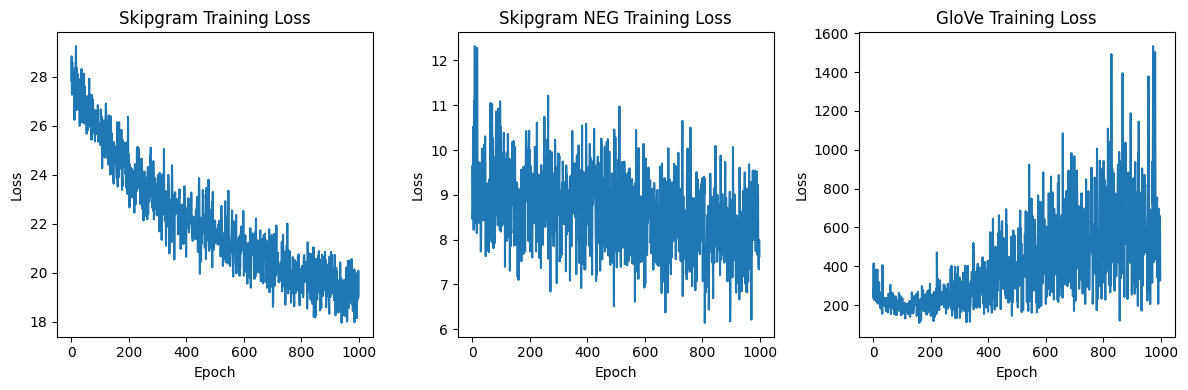

Training loss plot saved to model/training_loss.png


In [19]:
# Plot training losses
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(loss_skipgram)
plt.title('Skipgram Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 3, 2)
plt.plot(loss_neg)
plt.title('Skipgram NEG Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 3, 3)
plt.plot(loss_glove)
plt.title('GloVe Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.savefig('model/training_loss.png', dpi=150)
plt.show()
print("Training loss plot saved to model/training_loss.png")

### PCA 2D Visualization of Word Embeddings

**Information:**
- **PC1 (Principal Component 1):** The direction that captures the most variance in the embedding space. This is the "most important" axis for distinguishing words.
- **PC2 (Principal Component 2):** The direction that captures the second most variance, orthogonal (perpendicular) to PC1.

**Results:**
- Words that appear close together on the plot have similar embeddings (at least in these 2 principal dimensions).
- The percentage shown (e.g., "PC1: 8.0%, PC2: 7.0%") indicates how much of the total variance each component explains.
- Lower percentages are expected since we're compressing 50 dimensions into just 2. Most semantic information exists in the remaining dimensions.
- The axes themselves don't have inherent semantic meaning — they simply represent the directions of maximum spread in the data.

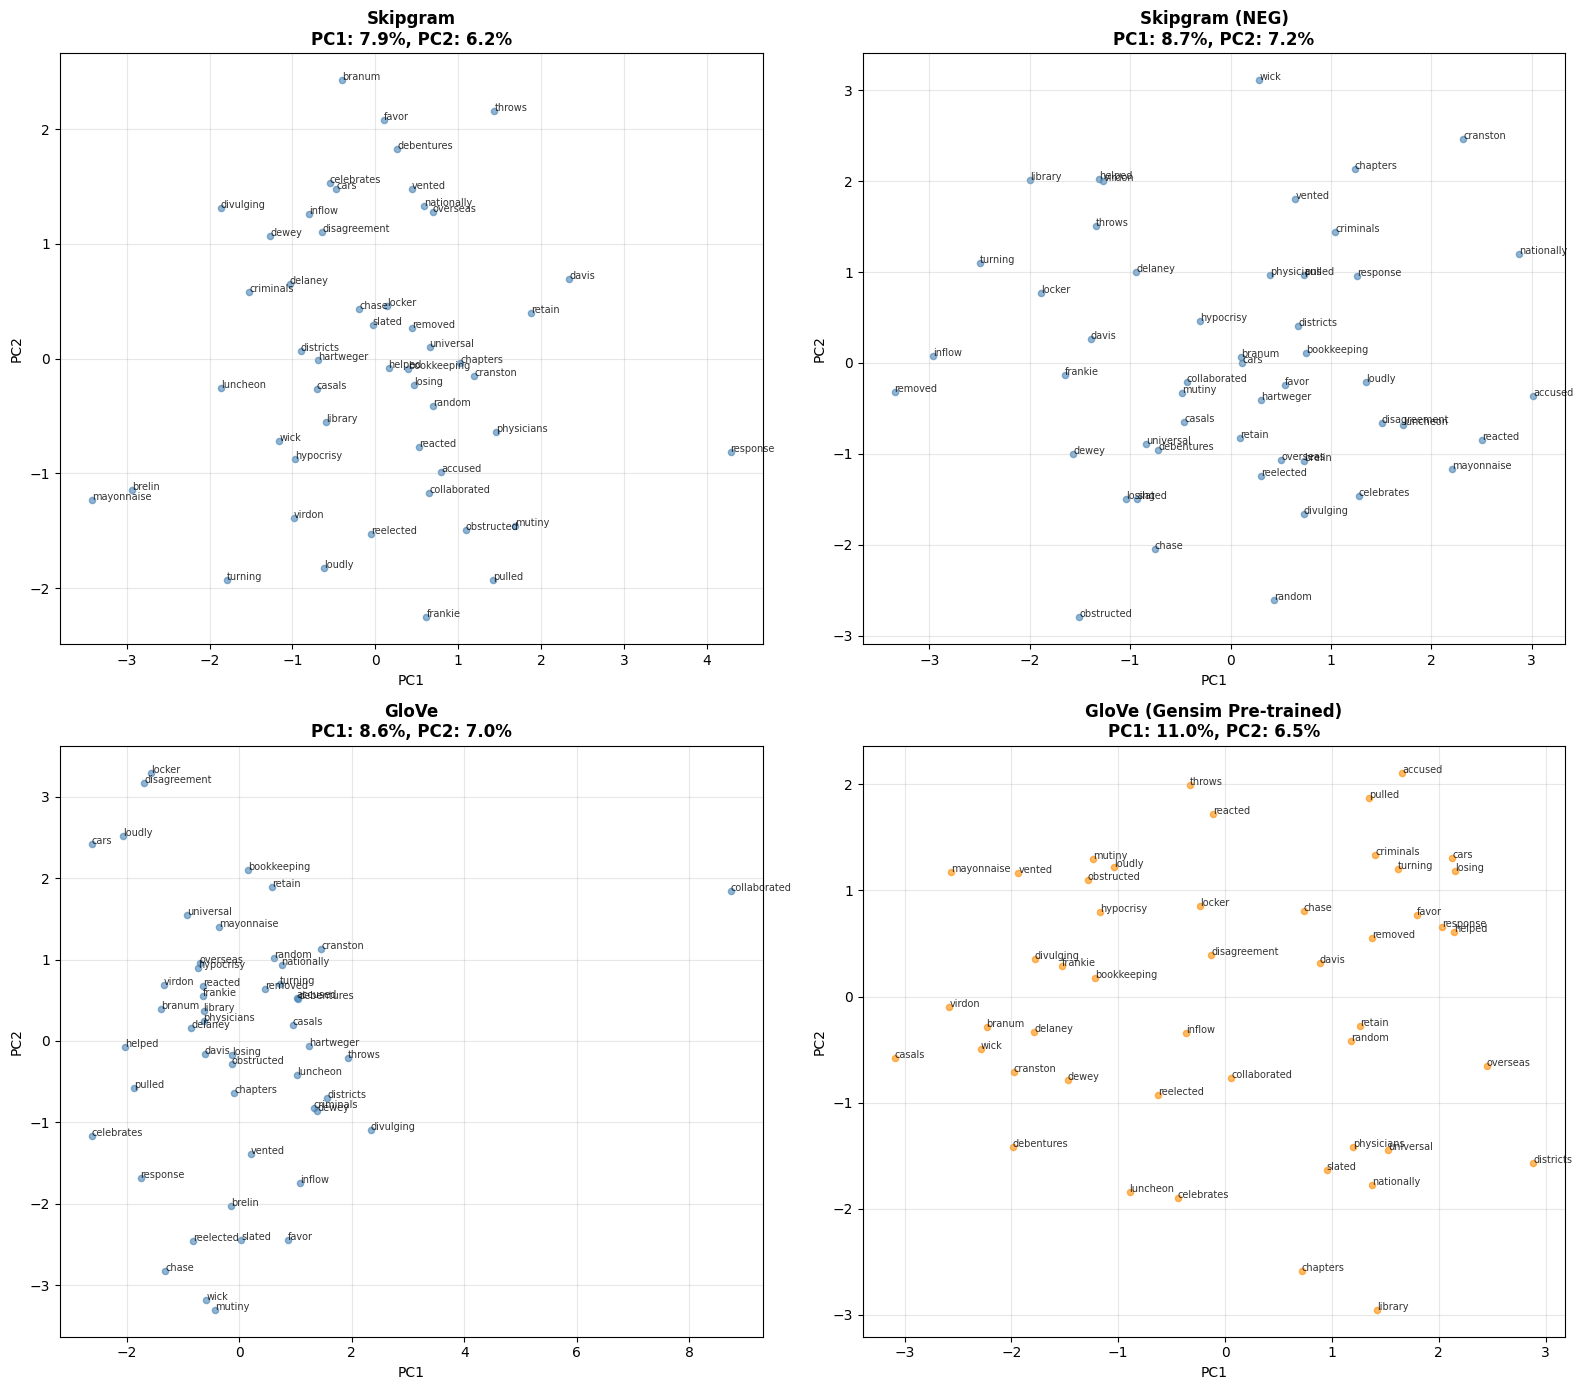

PCA visualization saved to model/pca_embeddings_comparison.png


In [20]:
from sklearn.decomposition import PCA

def plot_pca_embeddings(model, word2index, index2word, title, num_words=200, annotate_top=30):
    """Plot PCA 2D visualization of word embeddings."""
    # Get embeddings for top frequent words (skip UNK)
    words_to_plot = [w for w in list(word2index.keys())[:num_words] if w != '<UNK>']
    
    embeddings = []
    labels = []
    for word in words_to_plot:
        idx = word2index[word]
        embeddings.append(model.get_embedding(idx))
        labels.append(word)
    
    embeddings = np.array(embeddings)
    
    # Apply PCA (Principal Component Analysis)
    # Reduces dimensionality from 50 (emb_size) to 2 for visualization
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(embeddings)
    
    # Plot
    plt.figure(figsize=(12, 10))
    plt.scatter(reduced[:, 0], reduced[:, 1], alpha=0.6, s=20, c='steelblue')
    
    # Annotate some words (spread across the space)
    for i in range(min(annotate_top, len(labels))):
        plt.annotate(labels[i], (reduced[i, 0], reduced[i, 1]), 
                     fontsize=8, alpha=0.8,
                     xytext=(5, 5), textcoords='offset points')
    
    plt.title(f'PCA 2D Visualization - {title}', fontsize=14, fontweight='bold')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=11)
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    return pca.explained_variance_ratio_


# Create a 2x2 subplot comparison for all models
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

models_info = [
    (model_skipgram, "Skipgram", axes[0, 0]),
    (model_neg, "Skipgram (NEG)", axes[0, 1]),
    (model_glove, "GloVe", axes[1, 0]),
]

num_words = 50 # Number of words to plot (reduce to visualize cleanly)
annotate_top = 50 # Number of labels to show

for model, title, ax in models_info:
    words_to_plot = [w for w in list(word2index.keys())[:num_words] if w != '<UNK>']
    
    embeddings = []
    labels = []
    # Retrieve embeddings
    for word in words_to_plot:
        idx = word2index[word]
        embeddings.append(model.get_embedding(idx))
        labels.append(word)
    
    embeddings = np.array(embeddings)
    
    # Apply PCA
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(embeddings)
    
    # Plot on specific axes
    ax.scatter(reduced[:, 0], reduced[:, 1], alpha=0.6, s=20, c='steelblue')
    
    # Label points
    for i in range(min(annotate_top, len(labels))):
        ax.annotate(labels[i], (reduced[i, 0], reduced[i, 1]), 
                    fontsize=7, alpha=0.8)
    
    ax.set_title(f'{title}\nPC1: {pca.explained_variance_ratio_[0]*100:.1f}%, PC2: {pca.explained_variance_ratio_[1]*100:.1f}%', 
                 fontsize=12, fontweight='bold')
    ax.set_xlabel('PC1', fontsize=10)
    ax.set_ylabel('PC2', fontsize=10)
    ax.grid(True, alpha=0.3)

# Plot Gensim GloVe on the 4th subplot
if glove_gensim is not None:
    ax = axes[1, 1]
    # Get common words that exist in gensim model
    gensim_words = []
    gensim_embeddings = []
    for word in list(word2index.keys())[:num_words]:
        if word != '<UNK>':
            try:
                emb = glove_gensim[word]
                gensim_words.append(word)
                gensim_embeddings.append(emb)
            except KeyError:
                continue
    
    if len(gensim_embeddings) > 2:
        gensim_embeddings = np.array(gensim_embeddings)
        pca = PCA(n_components=2)
        reduced = pca.fit_transform(gensim_embeddings)
        
        ax.scatter(reduced[:, 0], reduced[:, 1], alpha=0.6, s=20, c='darkorange')
        for i in range(min(annotate_top, len(gensim_words))):
            ax.annotate(gensim_words[i], (reduced[i, 0], reduced[i, 1]), 
                        fontsize=7, alpha=0.8)
        
        ax.set_title(f'GloVe (Gensim Pre-trained)\nPC1: {pca.explained_variance_ratio_[0]*100:.1f}%, PC2: {pca.explained_variance_ratio_[1]*100:.1f}%', 
                     fontsize=12, fontweight='bold')
        ax.set_xlabel('PC1', fontsize=10)
        ax.set_ylabel('PC2', fontsize=10)
        ax.grid(True, alpha=0.3)
else:
    axes[1, 1].text(0.5, 0.5, 'Gensim model not available', 
                    ha='center', va='center', fontsize=12)
    axes[1, 1].set_title('GloVe (Gensim Pre-trained)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('model/pca_embeddings_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("PCA visualization saved to model/pca_embeddings_comparison.png")

## Task 3. Search similar context - Web Application Development - Develop a simple website with an input box for search queries. (2 points)
1) Implement a function to compute the dot product between the input query and your corpus and retrieve the top 10 most similar context.
2) You may need to learn web frameworks like Flask or Django for this task.

### Inference

In [21]:
# Demo: Search similar contexts
def compute_sentence_embedding(sentence, model, word2index):
    """Compute sentence embedding as average of word embeddings."""
    words = [w.lower() for w in sentence if w.lower() in word2index]
    if not words:
        return None
    
    # Retrieve embeddings for each word in the query/sentence
    embeddings = [model.get_embedding(word2index[w]) for w in words]
    # Average them to get a single vector representation
    return np.mean(embeddings, axis=0)


def search_similar_contexts(query, model, corpus, word2index, top_k=10):
    """Search for top-k most similar contexts using dot product."""
    # Compute query embedding
    query_words = query.lower().split()
    query_embed = compute_sentence_embedding(query_words, model, word2index)
    
    if query_embed is None:
        return []
    
    # Compute similarity with all sentences in the corpus
    similarities = []
    for i, sent in enumerate(corpus):
        sent_embed = compute_sentence_embedding(sent, model, word2index)
        if sent_embed is not None:
            # Use dot product as similarity measure
            similarity = np.dot(query_embed, sent_embed)
            similarities.append((i, similarity, ' '.join(sent)))
    
    # Sort by similarity score in descending order and get top-k
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:top_k]


# Test the search function
test_query = "government policy"
print(f"\nQuery: '{test_query}'")
print("\nTop 10 Similar Contexts:")

results = search_similar_contexts(test_query, model_skipgram, corpus, word2index)
for rank, (idx, sim, text) in enumerate(results, 1):
    print(f"{rank}. [Score: {sim:.4f}] {text[:100]}...")



Query: 'government policy'

Top 10 Similar Contexts:
1. [Score: 4.4882] dennis...
2. [Score: 3.9704] yogi...
3. [Score: 3.8571] bingles and bobbles...
4. [Score: 3.8500] instant rivalry...
5. [Score: 3.8333] leaders of industry...
6. [Score: 3.8052] swelling traffic...
7. [Score: 3.7152] legislators weary...
8. [Score: 3.4856] danger cited...
9. [Score: 3.4362] about...
10. [Score: 3.2746] bluebonnets and stagecoach silhouettes...


To run the web app:

  ```bash
# Create virtual environment with uv (recommended)
uv venv
uv sync

# Or with pip
python -m venv .venv
source .venv/bin/activate  # Linux/Mac
# or: .venv\Scripts\activate  # Windows
pip install -r requirements.txt

# Download NLTK data
python -c "import nltk; nltk.download('brown'); nltk.download('punkt')"

# Train models (run the notebook)
jupyter notebook tester.ipynb

# Run the web app
cd app
python app.py
  ```

Open http://localhost:5000 in your browser

## Conclusion

### Summary
In this assignment, I implemented three word embedding models from scratch:
- **Skipgram (Word2Vec)** — Full softmax approach, slower but mathematically complete
- **Skipgram with Negative Sampling** — Much faster training with comparable quality
- **GloVe** — Uses global co-occurrence statistics, fastest training time

### Key Findings

1. **Training Efficiency**: GloVe trains ~30x faster than Skipgram due to matrix factorization instead of iterative prediction.

2. **Corpus Size Matters**: Our small Brown corpus (~4,600 sentences) achieved 0% on analogy tasks, while Gensim's pre-trained model (trained on billions of words) achieved 55-94% accuracy. This demonstrates why large-scale training data is essential for capturing semantic relationships.

3. **Human Similarity Correlation**: All models showed positive correlation with human judgments (WordSim353), but the pre-trained model had 3-4x lower MSE, indicating better alignment with human perception.

4. **Negative Sampling Works**: The negative sampling approach achieved lower loss values than full softmax while training faster, confirming the findings from the original Word2Vec paper.

### Lessons Learned
- Word embeddings require massive training data to learn meaningful semantic relationships
- The analogy task (king - man + woman = queen) is particularly challenging and requires diverse contexts
- Pre-trained embeddings are valuable for downstream NLP tasks when training data is limited

### Future Improvements
- Train on larger corpus (e.g., Wikipedia, Common Crawl)
- Experiment with different embedding dimensions (100, 200, 300)
- Implement subword embeddings (FastText) for handling out-of-vocabulary words
- Add cosine similarity option alongside dot product in web app